# **DSFM Project**: Fraud detection & model evaluation (SOLUTION)

Creator: [Data Science for Managers - EPFL Program](https://www.dsfm.ch)  
Source:  [https://github.com/dsfm-org/code-bank.git](https://github.com/dsfm-org/code-bank.git)  
License: [MIT License](https://opensource.org/licenses/MIT). See open source [license](LICENSE) in the Code Bank repository. 

-------------

## Overview

In this project, we will explore different model evaluation metrics in the context of fraud detection.


First we define a __Data Generating Process__ (DGP) as a sigmoid function; then draw repeated samples from the DGP to allow for random variation; and finally we show the degree of __Bias__ and __Variance__ of the model at a given value of X. At the end of the project we can copare how the model performs at different levels of the polynomial expansion.  

-------------

## **Part 0**: Setup

### Import Packages

In [1]:
# Import packages
import lightgbm
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]
import seaborn as sn

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# Constants
TRAIN_PATH = 'data/train.csv'
TEST_PATH  = 'data/test.csv'
THRESHOLDS = [i/100 for i in range(0, 101)]
SEED       = 1234

## **Part 1**: Exploratory data analysis

In [3]:
# Load data
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

train_df.shape

(52819, 44)

In [4]:
# Target distribution in training data
train_df['isFraud'].value_counts() / len(train_df)

0    0.908764
1    0.091236
Name: isFraud, dtype: float64

In [5]:
# Split into training and testing data
feature_names = [col for col in train_df.columns if col not in ['TransactionID','isFraud']]

X_train, y_train = train_df[feature_names], train_df['isFraud']
X_test, y_test = test_df[feature_names], test_df['isFraud']

## **Part 2**: Fit model

In [6]:
# Train model
model = lightgbm.LGBMClassifier(random_state=SEED)
model.fit(X_train, y_train)
    
# Evaluate model
y_test_pred = model.predict_proba(X_test)[:, 1]

print('The first 10 predictions ...')
y_test_pred[:10]

The first 10 predictions ...


array([7.55574011e-05, 5.40324879e-02, 4.22816733e-02, 3.03902314e-02,
       1.22004713e-04, 9.76876524e-03, 1.38160193e-04, 1.08642948e-04,
       5.64559523e-02, 1.30052466e-04])

## **Part 3**: Compare evaluation metrics

### __a)__: Accuracy

$\frac{TP + TN}{TP + FP + TN + FN}$

Proportion of binary predictions that are correct, for a given threshold.

In [7]:
scores = []
for t in THRESHOLDS: 
    y_test_pred_binary = [int(i >= t) for i in y_test_pred]
    scores.append(accuracy_score(y_test, y_test_pred_binary))
    
max_t = THRESHOLDS[np.argmax(scores)]
y_test_pred_binary = [int(i >= max_t) for i in y_test_pred]
print('Maximum accuracy of {}% at threshold {}'.format(round(max(scores), 2)*100, max_t))


Maximum accuracy of 96.0% at threshold 0.41


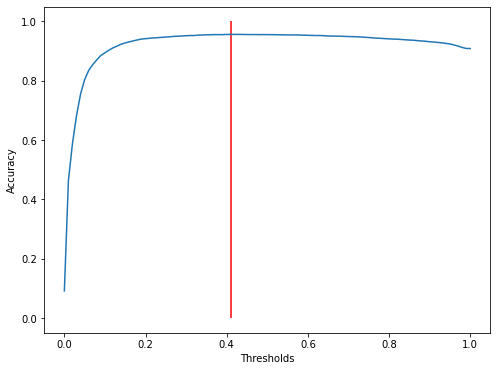

In [8]:
# Plot scores
plt.plot(THRESHOLDS, scores)
plt.vlines(max_t, ymin=0, ymax=1, color='r')
plt.xlabel('Thresholds')
plt.ylabel('Accuracy')
plt.show()

---

<img src="images/accuracy.png" width="800" height="800" align="center"/>


### __b)__: Confusion matrix

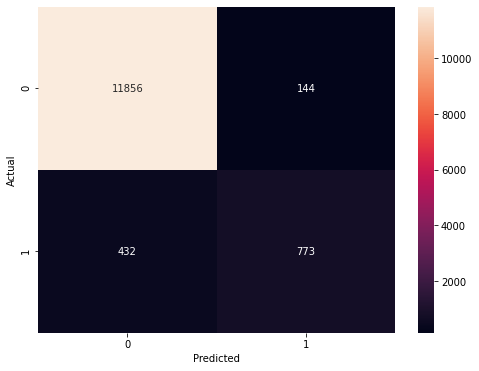

In [9]:
# Plot the confusion matrix 
sn.heatmap(confusion_matrix(y_test, y_test_pred_binary), annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### __c)__: True positive rate (recall, sensitivity)

$\frac{TP}{TP+FN}$

"Collect them all!" – High recall might give you some bad items, but it'll also return most of the good items.

How many fraudulent transactions do we “recall” out of all actual fraudulent transactions, for a given threshold.

In [10]:
scores = []
for t in THRESHOLDS: 
    y_test_pred_binary = [int(i >= t) for i in y_test_pred]
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
    true_positive_rate = tp / (tp + fn)
    scores.append(true_positive_rate)
    
max_t = THRESHOLDS[np.argmax(scores)]
y_test_pred_binary = [int(i >= max_t) for i in y_test_pred]
print('Maximum TPR of {}% at threshold {}'.format(round(max(scores), 4)*100, max_t))

Maximum TPR of 100.0% at threshold 0.0


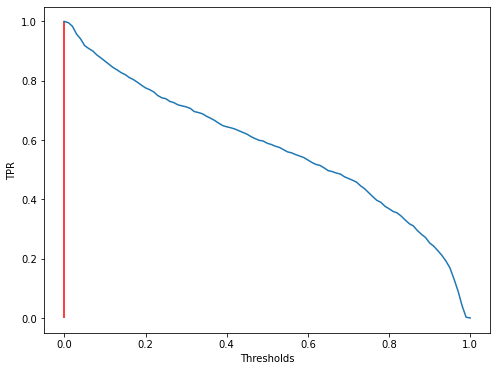

In [11]:
# Plot scores
plt.plot(THRESHOLDS, scores)
plt.vlines(max_t, ymin=0, ymax=1, color='r')
plt.xlabel('Thresholds')
plt.ylabel('TPR')
plt.show()

---

<img src="images/tpr.png" width="800" height="800" align="center"/>


### __d)__: False positive rate (Type I error)

$\frac{FP}{FP+TN}$

"False alarm!" 

The fraction of false alarms raised by the model, for a given threshold.

In [12]:
scores = []
for t in THRESHOLDS: 
    y_test_pred_binary = [int(i >= t) for i in y_test_pred]
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
    false_positive_rate = fp / (fp + tn)
    scores.append(false_positive_rate)
    
min_t = THRESHOLDS[np.argmin(scores)]
y_test_pred_binary = [int(i >= min_t) for i in y_test_pred]
print('Minimum FPR of {}% at threshold {}'.format(round(min(scores), 4)*100, min_t))


Minimum FPR of 0.0% at threshold 0.96


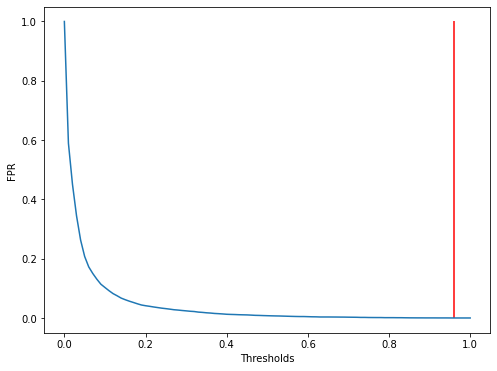

In [13]:
# Plot scores
plt.plot(THRESHOLDS, scores)
plt.vlines(min_t, ymin=0, ymax=1, color='r')
plt.xlabel('Thresholds')
plt.ylabel('FPR')
plt.show()

---

<img src="images/fpr.png" width="800" height="800" align="center"/>


### __e)__: False negative rate (Type II error)

$\frac{FN}{FN+TP}$

"Dammit, we missed it!"

The fraction of fraudulent transactions missed by the model, for a given threshold.

In [14]:
scores = []
for t in THRESHOLDS: 
    y_test_pred_binary = [int(i >= t) for i in y_test_pred]
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
    false_negative_rate = fn / (fn + tp)
    scores.append(false_negative_rate)
    
min_t = THRESHOLDS[np.argmin(scores)]
y_test_pred_binary = [int(i >= min_t) for i in y_test_pred]
print('Minimum FNR of {}% at threshold {}'.format(round(min(scores), 4)*100, min_t))


Minimum FNR of 0.0% at threshold 0.0


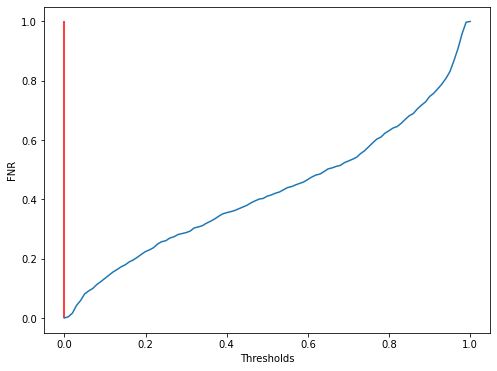

In [15]:
# Plot scores
plt.plot(THRESHOLDS, scores)
plt.vlines(min_t, ymin=0, ymax=1, color='r')
plt.xlabel('Thresholds')
plt.ylabel('FNR')
plt.show()

---

<img src="images/fnr.png" width="800" height="800" align="center"/>


### __f)__: Positive predictive value (precision)

$\frac{TP}{TP+FP}$

"Don't waste my time!" – High precision might leave some good ideas out, but what it returns is of high quality (i.e. very precise).

In [16]:
scores = []
for t in THRESHOLDS: 
    y_test_pred_binary = [int(i >= t) for i in y_test_pred]
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
    ppv = tp / (tp + fp)
    scores.append(ppv)
    
max_t = THRESHOLDS[np.argmax(scores)]
y_test_pred_binary = [int(i >= max_t) for i in y_test_pred]
print('Maximum PPV of {}% at threshold {}'.format(round(max(scores), 4)*100, max_t))

Maximum PPV of 100.0% at threshold 1.0


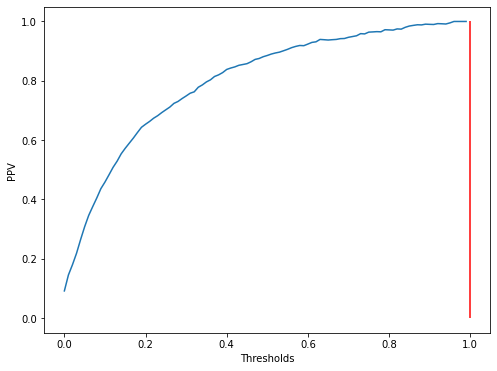

In [17]:
# Plot scores
plt.plot(THRESHOLDS, scores)
plt.vlines(max_t, ymin=0, ymax=1, color='r')
plt.xlabel('Thresholds')
plt.ylabel('PPV')
plt.show()

### __g)__: F1 score

"Let's just have one metric."

A balance between precision (accuracy over cases predicted to be positive) and recall (actual positive cases that correctly get a positive prediction), for a given threshold.

In [18]:
scores = []
for t in THRESHOLDS: 
    y_test_pred_binary = [int(i >= t) for i in y_test_pred]
    f1 = f1_score(y_test, y_test_pred_binary)
    scores.append(f1)
    
max_t = THRESHOLDS[np.argmax(scores)]
y_test_pred_binary = [int(i >= max_t) for i in y_test_pred]
print('Maximum F1 of {}% at threshold {}'.format(round(max(scores), 4)*100, max_t))

Maximum F1 of 73.42% at threshold 0.34


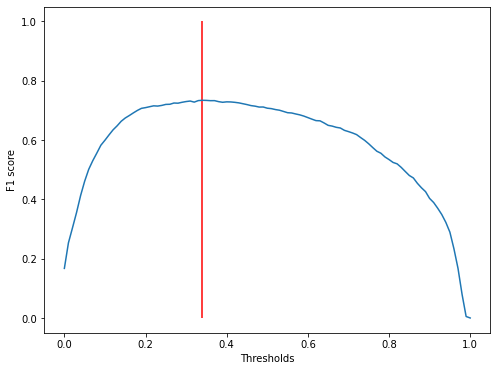

In [19]:
# Plot scores
plt.plot(THRESHOLDS, scores)
plt.vlines(max_t, ymin=0, ymax=1, color='r')
plt.xlabel('Thresholds')
plt.ylabel('F1 score')
plt.show()

---

<img src="images/f1.png" width="800" height="800" align="center"/>


## Bonus materials

- Google's Cassie Kozyrkov on precision and recall [on Youtube](https://www.youtube.com/watch?v=O4joFUqvz40)